In [1]:
import pandas as pd 

import matplotlib.pyplot as plt

# we use tensorflow to create our neural network for this experiment 
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn import metrics

import scikitplot as skplt
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [3]:
# import negative emotion labeled ads
dataset = pd.read_csv('./data/negative_emotion_dataset.csv').drop(columns= ['Unnamed: 0'])
dataset

In [6]:
norm_train, norm_test,  y_train, y_test = train_test_split(dataset['ad'], dataset['neg_emo'], test_size =0.2, random_state=42)

In [7]:
# data tokenization 
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')

# fit the tokenizer on the training documents
t.fit_on_texts(norm_train)
t.word_index['<PAD>'] = 0
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('fair’”', 46955), ('<PAD>', 0), 1)

In [8]:
# create tokenized data sequences to feed to the neural network 
train_sequences = t.texts_to_sequences(norm_train)
test_sequences = t.texts_to_sequences(norm_test)

In [9]:
MAX_SEQUENCE_LENGTH = 1000

# pad documents to equal length with 0 
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((19200, 1000), (4800, 1000))

In [10]:
def create_model(units, vocab_size, embedding_dim, maxlen, dropout = 0.2):
  '''
    Create a 
    Arguments : 
      num_filters: number of filters to use for the 1D convolution layer 
      kernel_size: kernal size used for convolution
      embedding_dim: embedding size 
      maxlen: input sequence length
      vectorize_layer : vectorization layer for turning input text to numerical sequences
      dropout : dropout rate used for Dropout regularization layer to minimize overfitting

    Returns : 
    A model with the folowing layers:  
            - An Embedding layer with embedding_dim dimension for each embedding 
            - A one dimentional (1D) convolutional neural network
            - A one dimentional global max pooling layer  
            - A fully connected layer with 10 units 
            - The output layer is one neuron with sigmoid activation producing the output label
            - Dropout layers added to minimize overfitting on the small datasets 
  '''
  model = Sequential([
      layers.Input(shape=(maxlen,)),
      layers.Embedding(input_dim = vocab_size , output_dim = embedding_dim, input_length=maxlen),
      layers.Dropout( rate = dropout ),
      layers.GlobalMaxPooling1D(),
      layers.Dropout( rate = dropout),
      layers.Dense(units, activation='relu'),
      layers.Dropout( rate = dropout ),
      layers.Dense(1, activation='sigmoid')              
  ])
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [11]:
VOCAB_SIZE = len(t.word_index)
EMBEDDING_DIM = 128
UNITS = 10

# Creating a neural net with randomly set paramteres as a baseline comparison model 
model = create_model(units = UNITS, vocab_size = VOCAB_SIZE, embedding_dim = EMBEDDING_DIM, maxlen = MAX_SEQUENCE_LENGTH )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 128)         6010368   
                                                                 
 dropout (Dropout)           (None, 1000, 128)         0         
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                        

In [13]:
# Train the neural net and evaluate results 
history = model.fit(X_train, y_train, epochs= 5, batch_size= 32,  shuffle=True, validation_split=0.2, verbose=1)

Epoch 1/5
480/480 [==============================] - 75s 154ms/step - loss: 0.5511 - accuracy: 0.7160 - val_loss: 0.3019 - val_accuracy: 0.9094
Epoch 2/5
480/480 [==============================] - 61s 127ms/step - loss: 0.2174 - accuracy: 0.9232 - val_loss: 0.1453 - val_accuracy: 0.9581
Epoch 3/5
480/480 [==============================] - 62s 128ms/step - loss: 0.0990 - accuracy: 0.9704 - val_loss: 0.0992 - val_accuracy: 0.9724
Epoch 4/5
480/480 [==============================] - 60s 126ms/step - loss: 0.0522 - accuracy: 0.9863 - val_loss: 0.0777 - val_accuracy: 0.9771
Epoch 5/5
480/480 [==============================] - 60s 125ms/step - loss: 0.0337 - accuracy: 0.9935 - val_loss: 0.0773 - val_accuracy: 0.9760


In [14]:
# model evaluation 
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

150/150 [==============================] - 1s 7ms/step - loss: 0.0828 - accuracy: 0.9706
Accuracy: 97.06%


In [15]:
# get model predictions 
prediction_probs = model.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]
predictions[:10]

150/150 [==============================] - 1s 7ms/step


[1, 1, 0, 0, 0, 1, 1, 0, 0, 0]

              precision    recall  f1-score   support

      no-neg       0.97      0.97      0.97      2399
         neg       0.97      0.97      0.97      2401

    accuracy                           0.97      4800
   macro avg       0.97      0.97      0.97      4800
weighted avg       0.97      0.97      0.97      4800

confusion matrix:
[[2329   70]
 [  71 2330]]



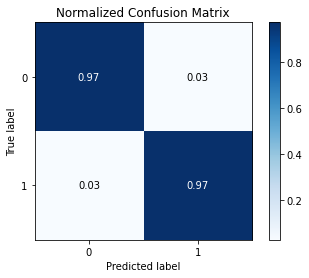

In [17]:
print(metrics.classification_report(y_test, predictions, target_names=[ 'no-neg', 'neg']))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, predictions))
print()

skplt.metrics.plot_confusion_matrix(y_test, predictions , normalize=True)
plt.show()

In [ ]:
####################################################################################################################

Accuracy: 83.87%
              precision    recall  f1-score   support

  no-neg_emo       0.88      0.88      0.88        82
     neg_emo       0.76      0.76      0.76        42

    accuracy                           0.84       124
   macro avg       0.82      0.82      0.82       124
weighted avg       0.84      0.84      0.84       124

confusion matrix:
[[72 10]
 [10 32]]



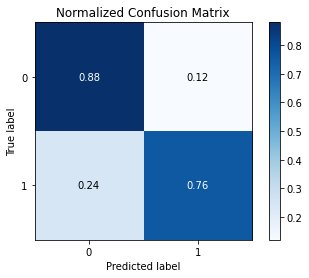

In [20]:
save = pd.read_csv('./data/sample_negative_emotion.csv')

norm_ = save['ad']
test_ = t.texts_to_sequences(norm_)
padded_ = tf.keras.preprocessing.sequence.pad_sequences(test_, maxlen=MAX_SEQUENCE_LENGTH)

pred_ = model.predict(padded_)
save['predicted'] = [1 if prob > 0.5 else 0 for prob in pred_]

scores = model.evaluate(padded_, save['neg_emo'], verbose =False)
print("Accuracy: %.2f%%" % (scores[1]*100))
print(metrics.classification_report(save['neg_emo'], save['predicted'], target_names=[ 'no-neg_emo', 'neg_emo']))
print("confusion matrix:")
print(metrics.confusion_matrix(save['neg_emo'], save['predicted']))
print()

skplt.metrics.plot_confusion_matrix(save['neg_emo'], save['predicted'], normalize=True)
plt.show()